In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6_new as ds
from copy import copy as dup
from scipy.integrate import odeint

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
#Setting up the system

nx = 501 # Number of points in simulation box
xmax = 50
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltaX = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot = np.ones(nx)
NQLL = ds.getNliq(Ntot,Nstar,Nbar)
Nice = Ntot-NQLL

<IPython.core.display.Javascript object>


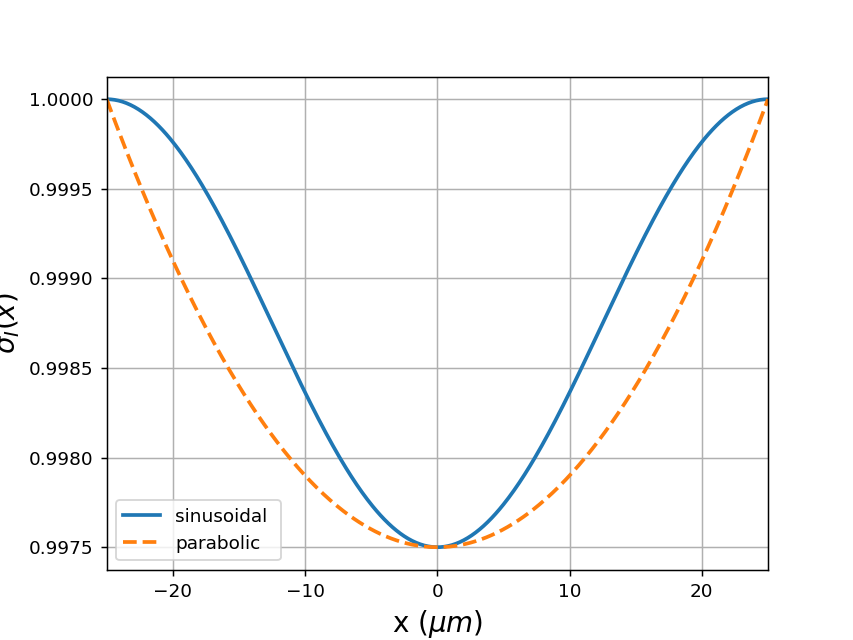

In [4]:
# Lay out the system
Ntot = NQLL + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 2e-4 # micrometers^2/microsecond
D = .1e-6 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltat = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltat = deprate * deltat

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid') #NOTE i think this should be nx not xmax
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
sigmastepstyle = 'sinusoid'
sigmastepstyle = 'parabolic'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# Graph sigma(x)
plt.figure()
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [5]:
# These are run control parameters

# Flag for explicit updating NQLL(Ntot) every step
updatingNQLL = False

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 100
else:
    countermax_0D = 100

# 1D run 
if uselayers:
    layermax_1D = 600
else:
    countermax_1D = 15000

In [6]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time)', dtmax)
print('deltat =', deltat)
print('deprate =', deprate, 'monolayers/us')
print('nmid', nmid)
print('N*', Nstar)
print('N*x2pi', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltaX', deltaX)
print('sigma_0 =', sigma0)
print('sigmastepmax =', sigmastepmax)
print('center reduction', center_reduction, '%')
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')

D = 1e-07 um^2/us 0.0001 x 10^-9 m^2/sec
deltat_max (Diffusion time) 100000.00000000003
deltat = 2000.0000000000007
deprate = 0.16333333333333333 monolayers/us
nmid 250
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.1
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


/Users/nesh/anaconda3/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


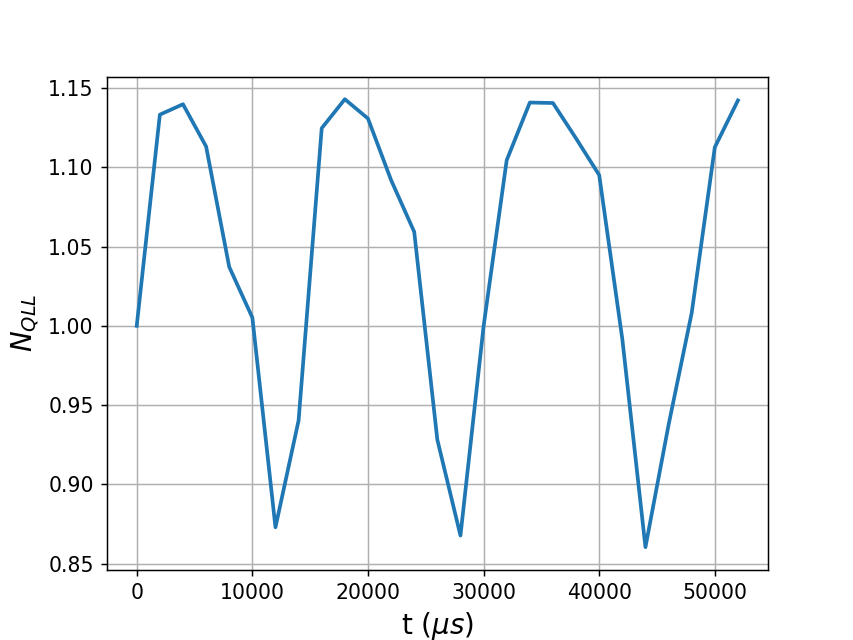

0-D Modeled growth rate, um/s 0.5813673399873907
0-D Modeled growth rate, ml/us 0.0019378911332913022
0-D Modeled alpha 0.059323197957897006


In [7]:
# This is the 0-d run
updatingNQLL = False

# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmastepmax, sigma0, deprate]

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to NQLL
    NQLLlast, Ntotlast = ylast

    if updatingNQLL:
        NQLLlast = ds.getNliq(Ntotlast,Nstar,Nbar) # This updates NQLLlast and ylast!
        ykeep_0D[counter][0] = NQLLlast # Saves the updated NQLL for this step
    Nicelast = Ntotlast - NQLLlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)

tkeep_0D_False = tkeep_0D
ykeep_0Darr_False = ykeep_0Darr

<IPython.core.display.Javascript object>


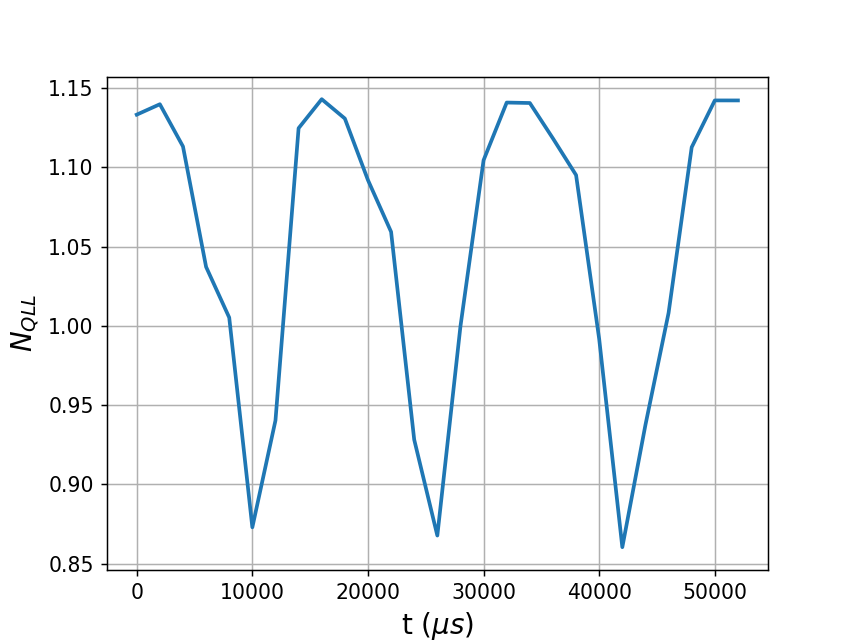

0-D Modeled growth rate, um/s 0.5813673399873907
0-D Modeled growth rate, ml/us 0.0019378911332913022
0-D Modeled alpha 0.059323197957897006


In [8]:
# This is the 0-d run, True
updatingNQLL = True

# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmastepmax, sigma0, deprate]

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to NQLL
    NQLLlast, Ntotlast = ylast

    if updatingNQLL:
        NQLLlast = ds.getNliq(Ntotlast,Nstar,Nbar) # This updates NQLLlast and ylast!
        ykeep_0D[counter][0] = NQLLlast # Saves the updated NQLL for this step
    Nicelast = Ntotlast - NQLLlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)

tkeep_0D_True = tkeep_0D
ykeep_0Darr_True = ykeep_0Darr

<IPython.core.display.Javascript object>


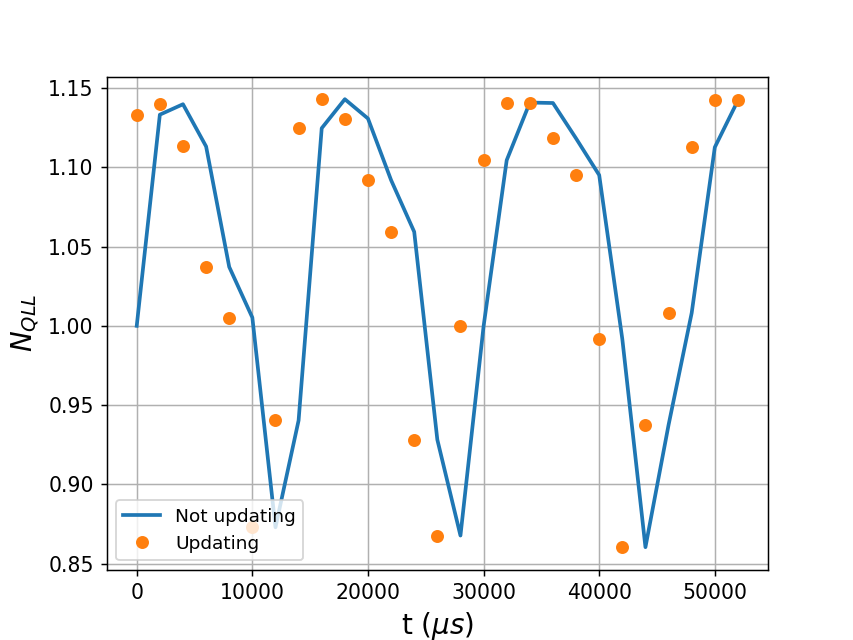

<IPython.core.display.Javascript object>


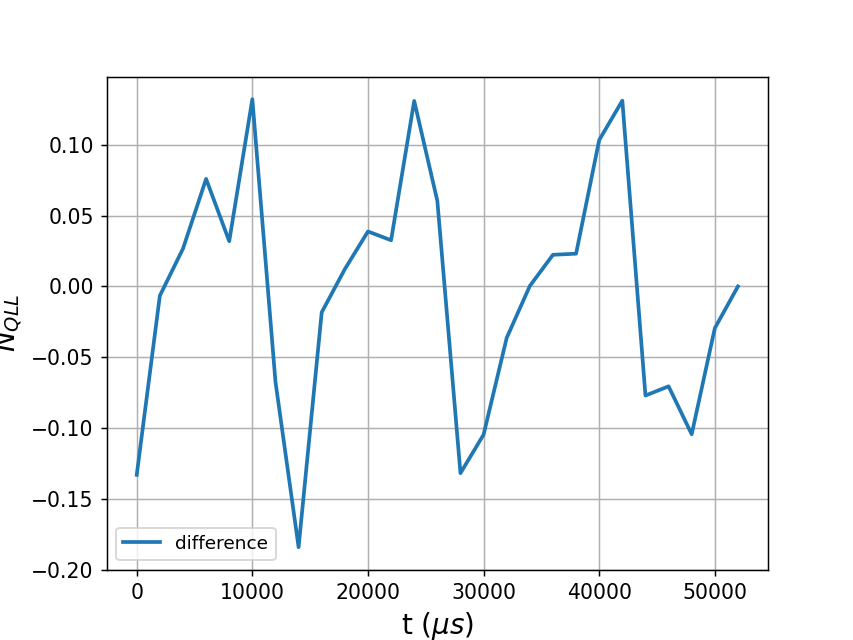

In [9]:
# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr_False[:,0],lw=linewidth,label='Not updating')
# plt.plot(tkeep_0D+deltat,ykeep_0Darr_True[:,0],'o',lw=linewidth)
plt.plot(tkeep_0D,ykeep_0Darr_True[:,0],'o',lw=linewidth,label='Updating')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.legend()

plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr_False[:,0]-ykeep_0Darr_True[:,0],lw=linewidth,label='difference')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.legend()

In [10]:
#Parameters for 1-D run 
L = xmax/2; print(L) # micrometers
c_r = center_reduction / 100; print(c_r) # dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
sigma_I = sigmastepmax; print('sigmaI ', sigma_I) # dimensionless
print(D, 'um^2/us') # D is in micrometers^2/microsecond
print(D*1e-6, 'm^2/s') # reporting as meters^2/second
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D
NSS = M*xfactor + B
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])

# This scales the surface diffusion coefficient
gamma = 1
# print('Testing D =', D*gamma, ' um^2/us, ', D*gamma/1e6, ' um^2/us ')

25.0
0.0025
0.16333333333333333
sigmaI  0.2
1e-07 um^2/us
9.999999999999999e-14 m^2/s
sinusoid: 11223.332775485926
paraboloic: 10390.879606931412


In [11]:
# This is the 1-d run
updatingNQLL = False

# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmastep, sigma0, deprate, DoverdeltaX2, nx, gamma] 

# Initial conditions for ODE solver
y0 = np.array([NQLL,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
NQLLkeep = [dup(NQLL)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
counter = 0
lastlayer = 0
lastdiff = 0

while True:
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)

    ylast = np.reshape(y[1],(2,nx))
    tlast += deltat
    counter += 1
        
    # Make some local copies, with possible updates to NQLL
    NQLL, Ntot = ylast
    if updatingNQLL:
        NQLL = ds.getNliq(Ntot,Nstar,Nbar) # This updates to remove any drift
        ylast[0] = NQLL
    Nice = Ntot - NQLL
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltat

    # Stuff into keeper arrays
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    NQLLkeep.append(NQLL)
    tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    if uselayers:
        if layer > layermax_1D-1:
            print('breaking because reached max number of layers')
            break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

0 0 0.13102894079283134
1 1 0.6756586945439063
2 2 0.05147339485539426
3 3 0.8116135149176866
4 4 0.816414685647576
5 5 0.840839852221011
6 6 0.868402874334361
7 7 0.13543672012744423
8 8 0.5917273174867859
9 9 0.9059258549947486
10 10 0.1611874311027286
11 11 0.9257243312544503
12 12 0.8937587259907076
13 13 0.9482511483124725
14 14 0.6256237759990952
15 15 0.9656109197691869
16 16 0.7233613669775636
17 17 0.9722405011980086
18 18 0.9876978159383754
19 19 0.992539921164294
20 20 1.0242763740893395
21 21 1.009537703393363
22 22 1.0164700718000645
23 23 1.0211592460330365
24 24 1.044039861188132
25 25 1.2453442794579672
26 26 1.5401477599487592
27 27 1.0601501921456347
28 28 1.05485504168567
29 29 1.0870670558422972
30 30 1.4831866741410522
31 31 1.7990145867667238
32 32 1.2438883182381204
33 33 1.0947250182304913
34 34 1.1407043859325157
35 35 1.788591557767596
36 36 1.8787453730942545
37 37 1.7820097486648976
38 38 1.1384778041953183
39 39 1.203581926955998
40 40 1.9027178330685857
41

322 322 8.08672820568512
323 323 8.125972978587697
324 324 8.647717065582299
325 325 8.854069422628868
326 326 8.118942157031256
327 327 8.114442322553884
328 328 8.249018839949315
329 329 8.880843182014587
330 330 8.872972187800201
331 331 8.646024903925252
332 332 8.13750374179051
333 333 8.257340124113455
334 334 8.899425361529154
335 335 8.907736213779117
336 336 8.237448650103318
337 337 8.213634100774755
338 338 8.922281160013597
339 339 8.921146832712168
340 340 8.822445197253387
341 341 8.196170773503638
342 342 8.562672975853218
343 343 8.936802639351129
344 344 8.944107015859004
345 345 8.89202203472206
346 346 8.31088736478813
347 347 8.778267431617621
348 348 8.956204048152074
349 349 8.957006408633617
350 350 8.87566748922103
351 351 8.44303084817335
352 352 8.967059039327353
353 353 8.97958186834984
354 354 8.981918984879314
355 355 8.9703977915172
356 356 8.837621458491412
357 357 8.990682884222736
358 358 8.995681215530794
359 359 8.999630486291323
360 360 9.00264979207

In [12]:
# Growth statistics
sec1 = time.time()

# minpoint = min(Nice)
minpoint = 0
ncorner = 4
print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmastep
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)


# Comparisons with 0-D model
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d/umpersec_over_mlyperus)
print( "0-D Modeled alpha", alpha_0d)
print( "Growth ratio 1D (corner)/0D", growthrate_entire[ncorner]/growthrate_0d)
print( "Growth ratio 1D (center)/0D", growthrate_entire[nmid]/growthrate_0d)
print( "Contribution of diffusion", (growthrate_entire[nmid]-growthrate_0d)/growthrate_0d*100, '%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
sec2 = time.time()
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

Height of Ice 0
1-D growth, corner 599.1965548792597
1-D growth, center 588.7276904442823
1-D Modeled growth rate, corner, um/s 0.18531852212760608
1-D Modeled growth rate, corner, ml/us 0.0006177284070920203
1-D Modeled growth rate, center, um/s 0.18208072900338626
1-D Modeled alpha, corner 0.018911554099260465
1-D Modeled alpha, center 0.018626231804346197
Difference, % -1.5087194495846599
0-D Modeled growth rate, um/s 0.5813673399873907
0-D Modeled growth rate, ml/us 0.0019378911332913022
0-D Modeled alpha 0.059323197957897006
Growth ratio 1D (corner)/0D 0.3187632145480093
Growth ratio 1D (center)/0D 0.3131939420734151
Contribution of diffusion -68.68060579265848 %
Libbrecht's predicted growth rate, um/s 1.8393582063217946
Libbrecht's predicted alpha 0.18768961288997904
Time taken: 0 min 0.0007119178771972656 secs


<IPython.core.display.Javascript object>


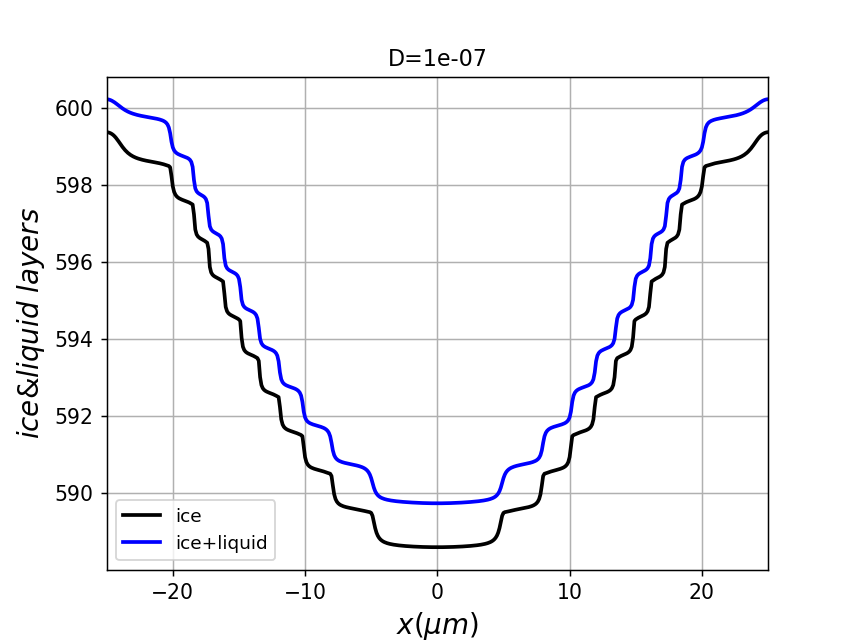

<IPython.core.display.Javascript object>


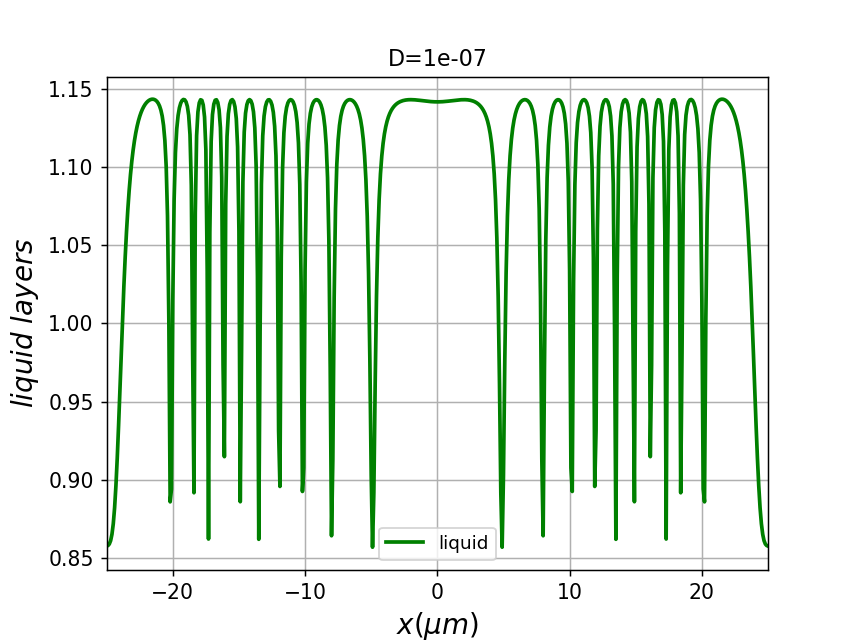

<IPython.core.display.Javascript object>


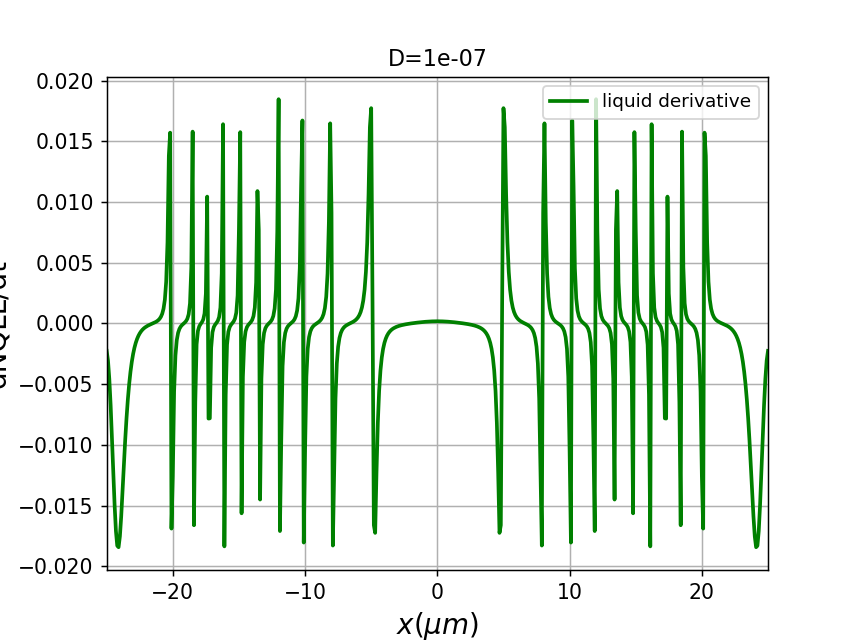

<IPython.core.display.Javascript object>


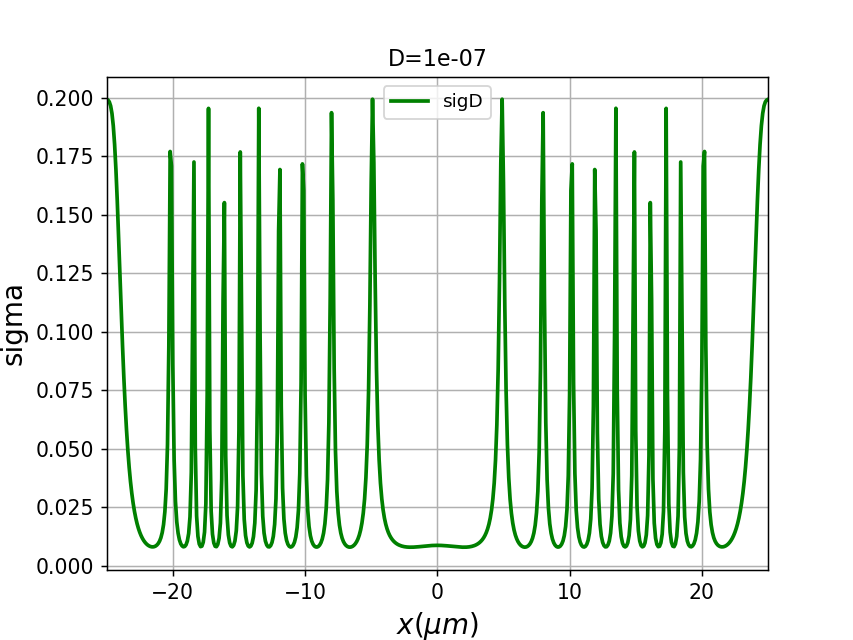

<IPython.core.display.Javascript object>


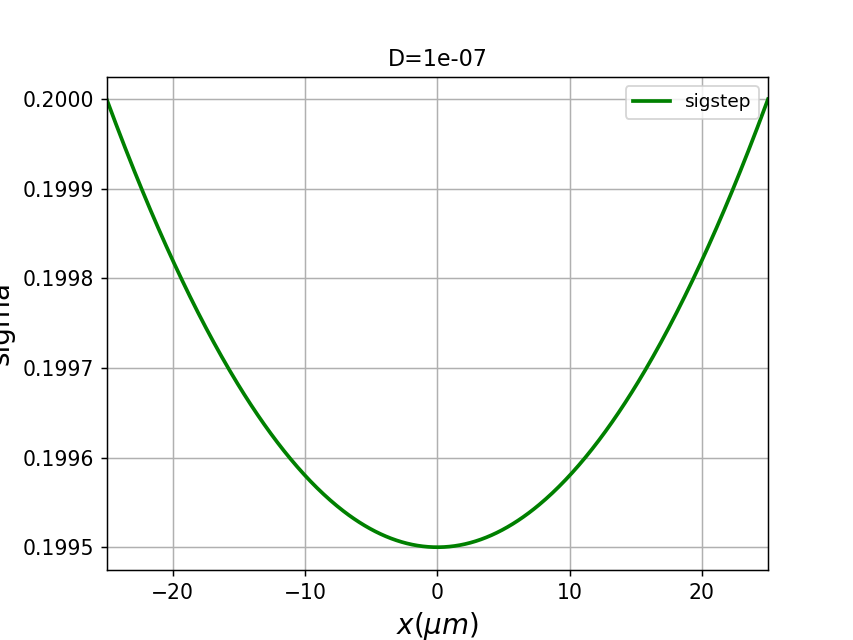

In [13]:
if updatingNQLL:
    title = 'Updating'
else:
    title = 'D='+str(D)

# Plot ice and liquid
plt.figure()
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, NQLL+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot liquid only
plt.figure()
plt.plot(x-xmid, NQLL, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot derivatives
dydx = ds.f1d(ylast,0,params)
dydx = np.reshape(dydx,(2,nx))
plt.figure()
plt.plot(x-xmid, dydx[0,:], 'g', label='liquid derivative', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('dNQLL/dt',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma
sigD = ds.f1d_sigD(ylast,0,params)
plt.figure()
plt.plot(x-xmid, sigD, 'g', label='sigD', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma
plt.figure()
plt.plot(x-xmid, sigmastep, 'g', label='sigstep', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

<IPython.core.display.Javascript object>


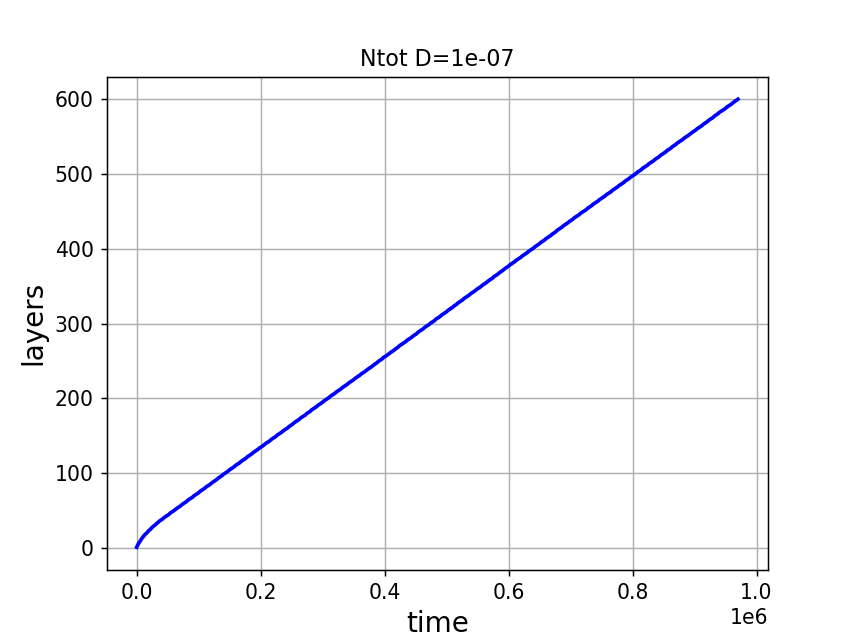

<IPython.core.display.Javascript object>


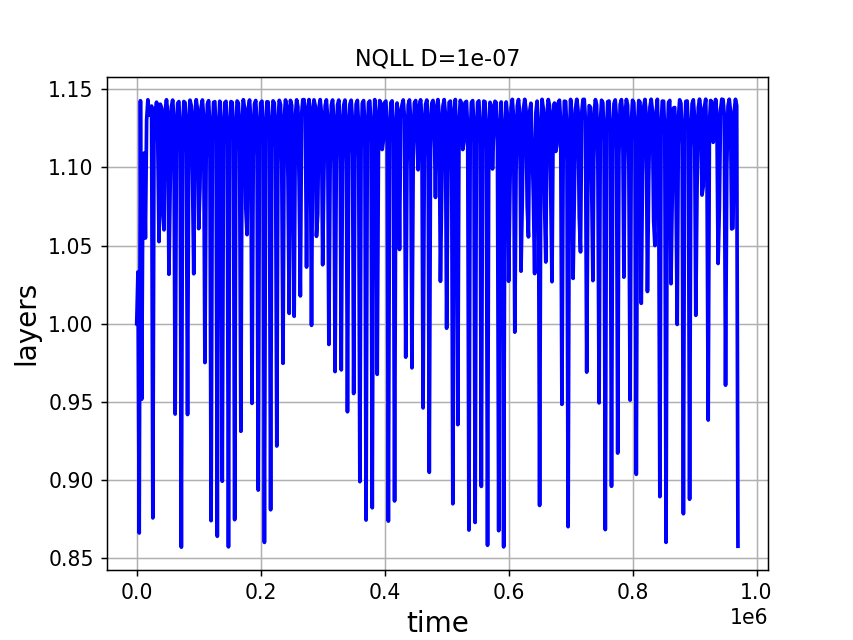

<IPython.core.display.Javascript object>


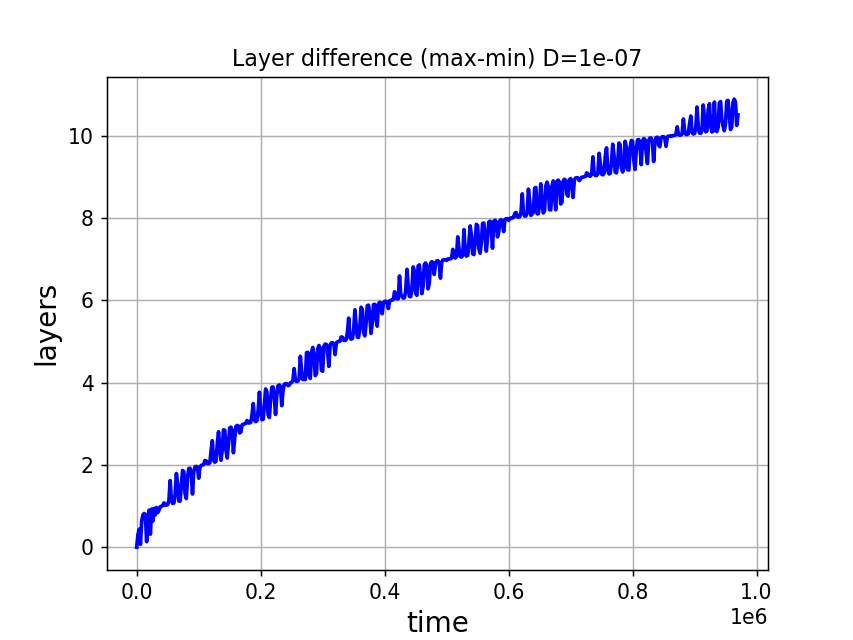

Text(0.5, 1.0, 'Layer difference (max-min) D=1e-07')

In [16]:
# The liquid over time
ix = 0
Ntotkeep_at_one_position = np.array(Ntotkeep)[:,ix]
plt.figure()
plt.plot(tkeep, Ntotkeep_at_one_position, 'b', label='total', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Ntot '+title)

# 
ix = 0
NQLLkeep_at_one_position = np.array(NQLLkeep)[:,ix]
plt.figure()
plt.plot(tkeep, NQLLkeep_at_one_position, 'b', label='liquid', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('NQLL '+title)


Ntot_difference = np.array(Ntotkeep)[:,-1] - np.array(Ntotkeep)[:,nmid]
plt.figure()
plt.plot(tkeep, Ntot_difference, 'b', label='number of steps', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Layer difference (max-min) '+title)

In [15]:
# Some other explorations ... the time required for an initial gaussian to diffuse
t1 = 160; print('Time_to_add_a_layer =', t1)
t2 = 2.5**2/D; print('Time to diffuse across a terrace =', t2)
t3 = 0.2**2/D; print('Time to diffuse into a step =', t3)
t4 = 0.001; print('Time for ice-QLL equilibration =', t4)

Time_to_add_a_layer = 160
Time to diffuse across a terrace = 62500000.0
Time to diffuse into a step = 400000.0000000001
Time for ice-QLL equilibration = 0.001
